In [1]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention
from torch_geometric.nn import global_mean_pool, global_max_pool
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import random
import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [2]:
# !pip install scipy==1.7.3

### Utility Functions

In [3]:


def set_device_and_seed(GPU=True, seed=0, gpu_name = "cuda:0"):
    torch.cuda.is_available()
    if GPU:
        device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device("cpu")
    print(f'Using {device}')

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)

        
    set_seed(seed)
    
    return device

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Setting torch, cuda, numpy and random seeds to {seed}")


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
def _count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)

In [4]:
# Setting random seed and device
GPU = True # Choose whether to use GPU
device =set_device_and_seed(GPU=False, seed=0, gpu_name='cuda:0')

Using cpu
Setting torch, cuda, numpy and random seeds to 0


### Load Data


In [5]:
orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5_cleaned_normalised_0207.csv"))
orig_df.describe()

,idno,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,...,sublobe_norm,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm,dircosx_norm,dircosy_norm,dircosz_norm
count,8.841330e+05,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.00000,884133.000000,884133.000000,884133.000000,...,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000
mean,5.383731e+06,10.962737,12.322837,2.780542,8.795393,180.396147,130.48361,142.894554,-0.009455,0.038263,...,0.462915,0.489945,0.519475,0.459284,0.477732,0.527059,0.471059,0.495273,0.519132,0.551936
std,1.770937e+06,9.992955,28.396421,1.493876,5.567604,120.961988,104.05128,25.471729,0.549856,0.546360,...,0.293032,0.191099,0.115638,0.149080,0.196813,0.107416,0.143148,0.274928,0.273180,0.310969
min,3.010007e+06,0.466797,-1.000000,0.000000,0.000000,1.000000,-1.00000,0.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.013247e+06,4.452000,4.294160,2.000000,4.000000,84.000000,47.00000,132.852000,-0.453427,-0.408248,...,0.210526,0.322884,0.445766,0.338470,0.304007,0.459572,0.357523,0.273286,0.295876,0.277778
50%,5.018404e+06,9.051960,6.539240,3.000000,9.000000,164.000000,106.00000,149.771000,0.000000,0.028006,...,0.473684,0.401372,0.526553,0.461700,0.379695,0.532158,0.473412,0.500000,0.514003,0.586458
75%,7.015895e+06,14.460800,10.895900,4.000000,13.000000,257.000000,193.00000,160.337000,0.446663,0.481543,...,0.684211,0.673250,0.599615,0.571430,0.669483,0.599461,0.577064,0.723332,0.740772,0.837862
max,8.024995e+06,149.707000,3176.890000,5.000000,19.000000,988.000000,922.00000,180.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

####  Class distribution of the labels 

In [7]:
# check all labels are in the orig_df dataset
print(len(label_df))
label_df = label_df.loc[label_df.idno.isin(orig_df.idno.unique())]
print(len(label_df))


3174
2891


In [8]:
pilot_df_w_labels = orig_df.merge(label_df, on='idno', how='left')
# drop nan labels
print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())

pilot_df_w_labels.dropna(subset='LL_1', inplace=True)

print(len(pilot_df_w_labels), pilot_df_w_labels.idno.nunique())

884133 2911
881351 2891


In [9]:
print("Label frequency distribution")



label_freq = label_df.groupby('LL_1').agg({'idno':lambda x:x.nunique()})
total = label_freq.idno.sum()
label_freq['percent'] = label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
label_freq.rename({'idno':'#participants'}, inplace=True)
label_freq

Label frequency distribution


,idno,percent
LL_1,,
Abs. RB7,163,5.64
Acc. B*,412,14.25
Acc. LB7,42,1.45
Standard,2102,72.71
Unclass.,172,5.95


In [10]:
# drop unclassified from training data
pilot_df_w_labels = pilot_df_w_labels.loc[~(pilot_df_w_labels.LL_1.str.lower().str.contains('unclass'))]


In [11]:
# make labels binary
binary_label = {
    
    'Abs. RB7': 1,
'Acc. B*': 1,
'Acc. LB7':1,
'Standard':0
    
    
}
pilot_df_w_labels['binaryLL_1'] = pilot_df_w_labels.LL_1.apply(lambda x: binary_label[x])

binary_label_freq = pilot_df_w_labels.groupby('binaryLL_1').agg({'idno':lambda x:x.nunique()})
total = binary_label_freq.idno.sum()
binary_label_freq['percent'] = binary_label_freq.idno.apply(lambda x:np.round(100*x/total, 2))
binary_label_freq.rename({'idno':'#participants'}, inplace=True)
binary_label_freq

,idno,percent
binaryLL_1,,
0,2102,77.31
1,617,22.69


In [12]:
# get the binary label df with dropping duplicates


In [13]:
# drop irrellevant cols
pilot_df = pilot_df_w_labels.copy().reset_index()
binary_label_df = pilot_df[['idno', 'binaryLL_1']].drop_duplicates(subset=['idno','binaryLL_1'])


### Train test split mask

In [14]:
# Get train test split masks

labels_list = binary_label_df["binaryLL_1"].tolist()
print("Overall Label frequency distribution", [(x, labels_list.count(x)) for x in set(labels_list)])

# stratified kfold
print(f"Getting train test split stratified on the {len(labels_list)} labels")
n_splits_test = 5
seed = 0
splitter_test = StratifiedKFold(n_splits=n_splits_test, shuffle=True, random_state=seed)
test_folds = list(splitter_test.split(np.array(labels_list), np.array(labels_list)))
train_idx, test_idx = test_folds[0]

print(len(train_idx), len(test_idx))
train_ids = binary_label_df.iloc[train_idx]['idno'].unique()
test_ids = binary_label_df.iloc[test_idx]['idno'].unique()


Overall Label frequency distribution [(0, 2102), (1, 617)]
Getting train test split stratified on the 2719 labels
2175 544


In [15]:
pilot_df_train = pilot_df.loc[pilot_df.idno.isin(train_ids)]
pilot_df_test = pilot_df.loc[pilot_df.idno.isin(test_ids)]
binary_label_df_train = binary_label_df.loc[binary_label_df.idno.isin(train_ids)]
binary_label_df_test = binary_label_df.loc[binary_label_df.idno.isin(test_ids)]
# [(0, 111496), (1, 32462)]
# [(0, 27874), (1, 8116)]
print("Overall Label frequency distribution", [(x, binary_label_df_test["binaryLL_1"].tolist().count(x)) for x in set(binary_label_df_test["binaryLL_1"].tolist())])
# [1/(27874/8116),1/(111496/32462) ] -- same label frequ dist of train - test 


Overall Label frequency distribution [(0, 421), (1, 123)]


In [16]:
# SAVE PILOT DF for training
pilot_df_train.to_csv('/home/sneha/e5_cleaned_normalised_w_labels_train.csv')
binary_label_df_train.to_csv('/home/sneha/e5_binary_labels_train.csv')
pilot_df_test.to_csv('/home/sneha/e5_cleaned_normalised_w_labels_test.csv')
binary_label_df_test.to_csv('/home/sneha/e5_binary_labels_test.csv')

## Make a graph sample & visualise in networkx

/tmp/ipykernel_3184/640908086.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)


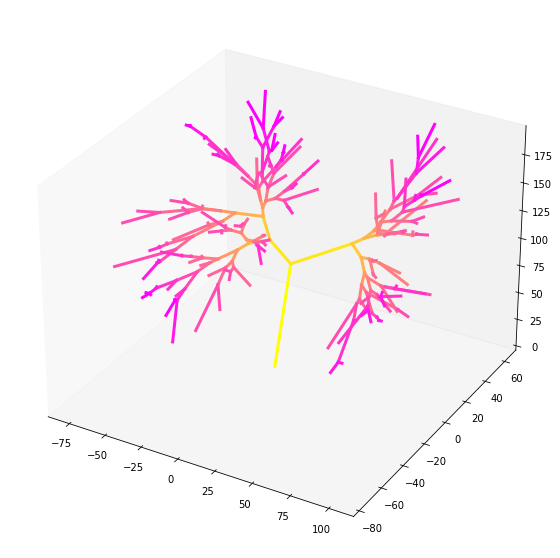

In [17]:
tree_w_coords = pilot_df[(pilot_df.idno ==3011950)]
val_min = tree_w_coords.weibel_generation.min()
val_max=tree_w_coords.weibel_generation.max()
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)


# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)

row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]
    ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=3, color= cmap(norm(row.weibel_generation)), label=row.anatomicalname)
ax.grid(False)
ax.set_facecolor(color=(1,1,1))
plt.show()

In [18]:
tree_w_coords.columns

Index(['index', 'idno', 'anatomicalname', 'centerlinelength', 'avginnerarea',
       'lobe', 'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx',
       'dircosy', 'dircosz', 'weibel_generation', 'QC', 'x', 'y', 'z',
       'parent_loc_x', 'parent_loc_y', 'parent_loc_z', 'endbpid_nn_in_lobe',
       'dist_nn_in_lobe', 'num_desc', 'max_path_length',
       'centerlinelength_norm', 'avginnerarea_norm', 'dist_nn_in_lobe_norm',
       'max_path_length_norm', 'angle_norm', 'weibel_generation_norm',
       'num_desc_norm', 'lobe_norm', 'sublobe_norm', 'x_norm', 'y_norm',
       'z_norm', 'parent_loc_x_norm', 'parent_loc_y_norm', 'parent_loc_z_norm',
       'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'LL_1', 'Standard',
       'Acc_B', 'Abs_RB7', 'Acc_LB7', 'Rare', 'Unclassified', 'binaryLL_1'],
      dtype='object')

In [19]:
tree_w_coords.head()[[ 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z','x_norm', 'y_norm', 'z_norm', 'parent_loc_x_norm',
       'parent_loc_y_norm', 'parent_loc_z_norm']]

,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm
29339,-1.065691,15.985358,80.459797,0.000000,0.000000,0.000000,0.486264,0.471203,0.261261,0.476800,0.412435,0.000000
29340,-12.858437,12.616001,100.675958,-1.065691,15.985358,80.459797,0.445803,0.458649,0.325408,0.472730,0.476055,0.268862
29341,38.909595,18.483814,111.690518,-1.065691,15.985358,80.459797,0.623417,0.480513,0.360357,0.472730,0.476055,0.268862
29342,-18.010936,13.131251,119.740224,-12.858437,12.616001,100.675958,0.428125,0.460569,0.385899,0.427692,0.462645,0.336416
29343,-25.499410,9.954747,95.353449,-12.858437,12.616001,100.675958,0.402433,0.448733,0.308519,0.427692,0.462645,0.336416


In [20]:
# nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm','lobe_norm',
       'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']

nodes = list(zip(tree_w_coords.endbpid, tree_w_coords[node_features].to_dict(orient='records')))
trachea_dict = dict.fromkeys(node_features, 0)
for i in ['x_norm', 'y_norm', 'z_norm']:
    trachea_dict[i] = tree_w_coords.loc[tree_w_coords.startbpid==-1][str('parent_loc_'+i)].item()
nodes =[(-1, trachea_dict)]+nodes
# nodes
list(trachea_dict.values())

list_of_nodes = tree_w_coords[node_features].to_dict(orient='records')
list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
len(list_of_lists_nodes), len(nodes)
x = torch.tensor(list_of_lists_nodes, dtype=torch.float)

In [21]:
print(tree_w_coords.reset_index().endbpid.to_dict())
relabel_map = {v:k+1 for k,v in tree_w_coords.reset_index().endbpid.to_dict().items()}
relabel_map

tree_w_coords.idno.unique().item()
# x_list_plus_trachea = [[0,0,0,-1]]+ df_w_coords.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
# x = torch.tensor(x_list_plus_trachea, dtype=torch.float)

{0: 1.0, 1: 6.0, 2: 7.0, 3: 19.0, 4: 18.0, 5: 11.0, 6: 10.0, 7: 15.0, 8: 14.0, 9: 17.0, 10: 16.0, 11: 21.0, 12: 20.0, 13: 22.0, 14: 23.0, 15: 25.0, 16: 24.0, 17: 26.0, 18: 27.0, 19: 28.0, 20: 29.0, 21: 30.0, 22: 31.0, 23: 33.0, 24: 32.0, 25: 34.0, 26: 35.0, 27: 37.0, 28: 36.0, 29: 39.0, 30: 38.0, 31: 40.0, 32: 41.0, 33: 42.0, 34: 43.0, 35: 45.0, 36: 44.0, 37: 47.0, 38: 46.0, 39: 49.0, 40: 48.0, 41: 50.0, 42: 51.0, 43: 53.0, 44: 52.0, 45: 54.0, 46: 55.0, 47: 57.0, 48: 56.0, 49: 59.0, 50: 58.0, 51: 60.0, 52: 61.0, 53: 62.0, 54: 63.0, 55: 64.0, 56: 65.0, 57: 66.0, 58: 67.0, 59: 69.0, 60: 68.0, 61: 71.0, 62: 70.0, 63: 73.0, 64: 72.0, 65: 74.0, 66: 75.0, 67: 77.0, 68: 76.0, 69: 78.0, 70: 79.0, 71: 81.0, 72: 80.0, 73: 82.0, 74: 83.0, 75: 84.0, 76: 85.0, 77: 87.0, 78: 86.0, 79: 88.0, 80: 89.0, 81: 91.0, 82: 90.0, 83: 93.0, 84: 92.0, 85: 95.0, 86: 94.0, 87: 96.0, 88: 97.0, 89: 98.0, 90: 99.0, 91: 100.0, 92: 101.0, 93: 103.0, 94: 102.0, 95: 104.0, 96: 105.0, 97: 107.0, 98: 106.0, 99: 109.0, 100

3011950

In [22]:
# edges and features: TODO include all features relevant + NORMALISE
edge_features = ['centerlinelength_norm',
       'avginnerarea_norm']

edges = list(zip(tree_w_coords.startbpid, tree_w_coords.endbpid))
edges_with_features = dict(zip(edges,tree_w_coords[edge_features].to_dict(orient='records')))


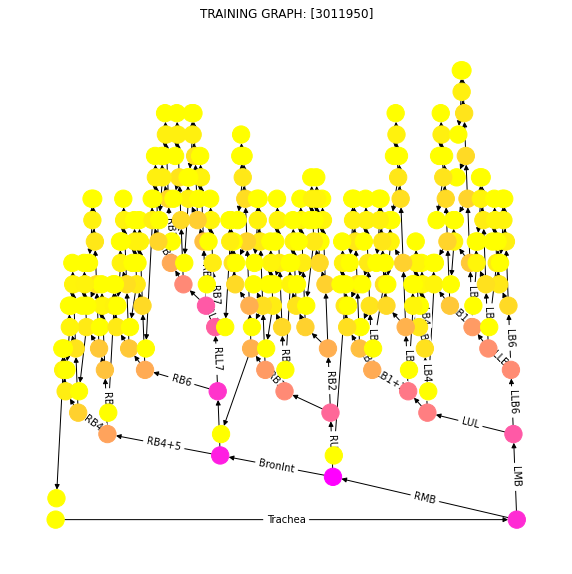

In [23]:


g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

nx.set_edge_attributes(g,edges_with_features)
# print(g.edges(data=True))
# print(g.nodes(data=True))
# 2D projection of tree (excluding the trachea itself)
col = nx.betweenness_centrality(g)

val_min = min(col.values())
val_max=max(col.values())
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['spring'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)
cmap_nodes = [cmap(norm(col[node])) for node in g.nodes()]

# cmap_nodes = [cmap(norm(g.nodes[node]['weibel_generation']))for node in g.nodes() if not len(g.nodes[node])==0]
# labels = {node:g.nodes[node]['anatomicalname'] for node in g.nodes() if (not len(g.nodes[node])==0) & (len(g.nodes[node]['anatomicalname']) > 1)}
edge_labels = {edge:tree_w_coords.loc[tree_w_coords.endbpid == edge[1]]['anatomicalname'].item() for edge in g.edges() }
# print('edge', edge_labels)
pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)

f, ax = plt.subplots(figsize=(10,10))
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
nx.draw_networkx_edge_labels(g, pos,
                          edge_labels,
                             font_color='k',
                             font_size='10',
                          label_pos=0.5,
                          )
plt.title(f'TRAINING GRAPH: {tree_w_coords.idno.unique()}')
# plt.colorbar(cmap_nodes, cax=cax, orientation='vertical')
plt.show()

## Pytorch Dataset for Geometric

- TODO drop the unclassified examples
- MAKE BINARY LABELS
- WEIGHTED LOSS
- SPLIT TRAIN TEST
- LOOK INTO BETTER GCNS
- FEATURE ENGINEERING AND NORMALISATION

In [24]:

# g = torch_geometric.utils.to_networkx(# torch dataset, to_undirected=False)
# nx.draw_planar(g, with_labels=True)
# g.edges()

# WHAT IS RAW PATHS

In [25]:
class CustomDataset(torch_geometric.data.Dataset):
    def __init__(self,root, filename_data, filename_labels, test=False, transform=None, pre_transform=None):
        '''
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        filename_data = contains X features for nodes + edges (csv)
        filename_labels= contains Y labels for graphs (csv)
        
        IGNORE OTHERR INPUTS __> NOTE TEST IS FIXED AS FASLE NOT SURE WHAT IT DOES MAYBE FOR INDUCTIVE LEARNING
        
        '''
        # super(CustomDataset, self).__init__(root, transform, pre_transform)
        self.test = False
        self.filename_data = filename_data
        self.filename_labels = filename_labels
        self.node_map = {}
        super(CustomDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped: NOTE NOT SURE WHAT THIS IS"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = self._process_labels()
        graph_ids = self.data.idno.unique()
        
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant (resetindex is important for node relabelling)
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df,index=i)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
    
    
    def _process_labels(self):
        '''
        Reads label df - checks its binary 0,1 labels (REQUIRES COLUMN binaryLL_1) if not returns an error 
        Keeps only rows that match idnos in self.data_df which is processed first
        measures class proportions and saves to self.class_proportions
        returns a df which has a label per idno with label in col called 'y'
        '''
        #(NOTE THIS IS WRONG YOU NEED TO DROP UNALBELLED)
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        # binarise 
        assert 'binaryLL_1' in label_df.columns, "The column binaryLL_1 cannot be found"
        # drop unnecessary cols
        
        # drop rows not matching to data ids
        data_df =  pd.read_csv(os.path.abspath(self.filename_data))
        label_df_small = label_df.loc[label_df.idno.isin(data_df.idno.unique())]
        
        print("# Graphs", len(label_df_small), "Label Frequency", Counter(label_df_small['binaryLL_1'].to_list()))
        self.class_proportions = {k:v/len(label_df_small) for k,v in Counter(label_df_small['binaryLL_1'].to_list()).items()}
        print(f"Class proportions: {self.class_proportions}")
        return label_df_small
    
    def _get_edge_adjacency(self,df, index):
        '''
        NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        Turns endbpid 1 > 1, if the next one in the df is endbpid=6 it becomes 2 etc so that the endbpids are in order from 1 to max (index+1)
        Adds trachea (node 0)
        applyys relabelling to start and endbpid based on the dict 
        returns torch tensor in COO format which is a parallel list [[source_node_list], [corresponding_end_node_list]]
        in this format, at list[0][2] and list[1][2] will be source-end node of the second edge in the list
        '''
        # reindex start / endbpids
        
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # save mapping
        self.node_map[index] = (df.idno.unique().item(), relabel_map)
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        '''
        DF already contains normalised features
        Feature names in node_features
        Format to return is a tensor of shape num_nodes x node_feature_dim with dtype float 
        assumes ordered in ascending order with nodes 0 and up in integers (so node = index / row num)
        '''
        # nodes and features (pos, direction,lobe + sublobe categorical, angle to parent, weibel gen, dist to nearest neighbor in lobe, max path length to leaf, num descendents of node)
        node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','lobe_norm',
               'sublobe_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm']
        # adding trachea info to top of list
        trachea_dict = dict.fromkeys(node_features, 0)
        for i in ['x_norm', 'y_norm', 'z_norm']:
            trachea_dict[i] = tree_w_coords.loc[tree_w_coords.startbpid==-1][str('parent_loc_'+i)].item()
        
        # currently usnig as features 
        list_of_nodes = df[node_features].to_dict(orient='records')
        # add trachea to nodes
        list_of_lists_nodes =[list(trachea_dict.values())]+ [list(node_feature.values()) for node_feature in list_of_nodes]
        x = torch.tensor(list_of_lists_nodes, dtype=torch.float)
#         print("Shape node features", x.shape)
        return x

    def _get_edge_features(self,df):
        '''
        get matrix of shape [# edges, edge feature size] with type float
        '''
        edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']
        edge_norm = df[edge_feature_names].values
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df):
        '''
        for the selected idno, returns value in binaryLL_1 col as an integer
        '''
        return torch.tensor(label_df.loc[label_df.idno==idno,
                 'binaryLL_1'].values, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)


my_data_train  = CustomDataset('data_train/', '/home/sneha/e5_cleaned_normalised_w_labels_train.csv',"/home/sneha/e5_binary_labels_train.csv")#, train_val_test_mask_path='', train_type='train')
my_data_test  = CustomDataset('data_test/', '/home/sneha/e5_cleaned_normalised_w_labels_test.csv',"/home/sneha/e5_binary_labels_test.csv")

Processing...


# Graphs 2175 Label Frequency Counter({0: 1681, 1: 494})
Class proportions: {0: 0.7728735632183908, 1: 0.2271264367816092}


100%|██████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:18<00:00, 115.40it/s]
Done!
Processing...


# Graphs 544 Label Frequency Counter({0: 421, 1: 123})
Class proportions: {1: 0.2261029411764706, 0: 0.7738970588235294}


100%|████████████████████████████████████████████████████████████████████████████████| 544/544 [00:04<00:00, 115.39it/s]
Done!


### MODELS

# YOU ARE HERE - use colab tutorial to get how to do ifull graph classification

https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing


PyTorch Geometric provides this functionality via torch_geometric.nn.global_mean_pool, which takes in the node embeddings of all nodes in the mini-batch and the assignment vector batch to compute a graph embedding of size [batch_size, hidden_channels] for each graph in the batch.




class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [26]:
class GAT(torch.nn.Module):
    def __init__(self, 
                 input_dim_node=13,
                 edge_dim=2, 
                 hidden_dim1=8,
                 hidden_dim2 = 8,
                 heads1=8,
                 heads2 = 1,
                 num_classes=1,
                 dropout=0.6,
                 agg='max'
                    
                
                
                ):
        super(GAT, self).__init__()
        self.hid1 = hidden_dim1
        self.hid2 = hidden_dim2
        self.head1 = heads1
        self.head2 = heads2
        self.node_dim = input_dim_node
        self.edge_dim = edge_dim
        self.dropout = dropout
        self.num_classes = num_classes
        assert agg.lower() in ['max', 'mean','attn', 'none']
        self.agg = agg
        
        
        self.conv1 = GATConv(self.node_dim, self.hid1, edge_dim=self.edge_dim, heads=self.head1, dropout=dropout)
        self.conv2 = GATConv(self.hid1*self.head1, self.hid2, edge_dim=self.edge_dim,concat=False,
                             heads=self.head2, dropout=dropout)
        
        
        self.lin1 = nn.Linear(self.hid2*self.head2, 1) # computes attention weights
#         self.lin2 =  nn.Linear(self.hid2*self.head2, 1) # transfomrs features F --> V before you multiply + add w attention weights
        self.att = GlobalAttention(gate_nn=self.lin1)
        
        # if global mean pool
        self.classifier = nn.Sequential(
                                        nn.Linear(self.hid2*self.head2, self.num_classes),
                                        nn.Sigmoid()
                                    )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
                
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
#         print("conv1", x.shape)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
#         print("conv2", x.shape)
        per_node = F.log_softmax(x, dim=1)
#         print("per node", per_node.shape)
        
        # 2. Readout layer
        if self.agg == 'attn':
            x = self.att(x, batch)  # [batch_size, hidden_channels]
        elif self.agg == 'mean':
            x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        elif self.agg == 'max':
            x = global_max_pool(x,batch) # [batch_size, hidden_channels]
        elif self.agg == 'none':
            # [batch_size*num_nodes_per_graph, hidden_channels]
            x = x
#         print("readout",self.agg, x.shape)
            
        
        # Linear classifier to get per graph label (if agg is not none) or per node label
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
#         print("post linear", x.shape)
        return x
    
model = GAT()
print(model)
_count_parameters(model)

GAT(
  (conv1): GATConv(13, 8, heads=8)
  (conv2): GATConv(64, 8, heads=1)
  (lin1): Linear(in_features=8, out_features=1, bias=True)
  (att): GlobalAttention(gate_nn=Linear(in_features=8, out_features=1, bias=True), nn=None)
  (classifier): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


1794

## Training Pipeline

In [27]:


# make training function
def train_model(model, 
                optimizer,
                train_loader, 
                device,
                num_epochs, 
                count_epochs=0,
                verbose=True, 
                scheduler=None, 
                accum_iter=1, 
                class_weight=None):
    
    plotting_dict_train = {"loss":[], "accuracy": []}
    noisy_label=False
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        denominator_loss = 0
        denominator_acc=0
        for batch_idx, data in list(enumerate(train_loader)):
            data = data.to(device)
            batch_size = data.num_graphs
            batch_vector = data.batch
            denominator_loss+=batch_size
            # reset gradients
            if batch_idx % accum_iter ==0:
                optimizer.zero_grad()

            # conduct a forward pass
            out = model(data)
            y_per_graph = data.y.float()
            
              # Noisy vs per graph labelling depending on model type
            if (out.squeeze()).shape != data.y.shape:
                noisy_label = True
                y = torch.take(data.y.float(), batch_vector) # repeat label shape
#                 print('Noisy labelling', y.shape)
                # denominator for accuracy etc. is y.shape from here (to average out per node accuracy)
            else:
                y = data.y.float()
#                 print('Graph labelling', y.shape)
                # denominatro here is y.shape (per graph to avg out graph accuracy)
            
            denominator_acc +=y.shape[0]
            # calculate loss and metrics
            pred = out > 0.5
            pred = pred.long()
#             print(pred.unique())
            correct += pred.eq(y.view_as(pred)).sum().item()
            
            
            if class_weight is not None:
                weights = torch.take(class_weight.to(device), y.long()) # class_weight has weight for 0 in posnt 0 and 1 in 1
#                 print("weights", weights, y, sep='\n')
                loss = F.binary_cross_entropy(out.squeeze(),y.float(), weight=weights.float())
            else:
                loss = F.binary_cross_entropy(out.squeeze(),y)
            train_loss += loss.item()

            # backward pass, normalising for gradient accumulation
            loss = loss / accum_iter
            loss.backward()
            
            # step
            if (batch_idx % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()

                
            if verbose:
                print('Epoch: {}, Batch: {}, Loss: {:.2f}'.format(epoch+count_epochs, batch_idx, loss.item()))
        # calculate loss and error for epoch
        train_loss /= denominator_loss # loss is already mean over the nodes so just divide by num graphs in batch
        accuracy = correct / denominator_acc # if doing noisy labelling need to do length of vector
        plotting_dict_train["loss"].append(train_loss)
        plotting_dict_train["accuracy"].append(accuracy)
        
        # step at the end of each epoch
        if scheduler is not None:
            scheduler.step()
            
            if scheduler is not None:
                last_lr = scheduler.get_last_lr()[0]
            
        print('Epoch: {}, Train Loss: {:.5f}, Train Accuracy: {:.5f}'.format(epoch+count_epochs, train_loss, accuracy))
        
    return plotting_dict_train


In [28]:

def _vis_graph_example(dataloader,model, index, pilot_df_w_labels, visualise_g = False, save_path = None):
    data = dataloader.dataset[index]
    print(data)
    label = data.y
    g = to_networkx(data)
    # get relabelmap
    idno, relabel = dataloader.dataset.node_map[index]
    # map to original df
    vis_graph  =pilot_df_w_labels.loc[pilot_df_w_labels.idno==idno]
    print(f"This graph is for id: {idno}")
    display(vis_graph.head())
    # get the relabelling to match the pytorch graph 
    vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
    vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])
#     display(vis_graph[['startbpid', 'endbpid']+node_features + ['parent_loc_x_norm','parent_loc_y_norm']])
#     print(data.x)
    print("Getting model preds per node (node model needs to be a per node one)")
    model.eval()
    preds = model(data.to(device))
    preds = preds.cpu().detach().numpy() # take off cuda
    
    
    # drawing graph in networkx & matplotlib
    cmap = mpl.colormaps['spring'].reversed()
    vmin, vmax = 0,1
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cmap_nodes = [cmap(norm(preds[node])) for node in g.nodes()]
    edge_labels = {edge:vis_graph.loc[vis_graph.end_node == edge[1]]['anatomicalname'].item() for edge in g.edges()}
    pos = nx.planar_layout(g, scale=1, center=(0,0), dim=2)
    
    
    if visualise_g:
        f, ax = plt.subplots(figsize=(10,10))
        nx.draw(g,pos=pos, with_labels=False,node_color=cmap_nodes, ax=ax)
        nx.draw_networkx_edge_labels(g, pos,
                                  edge_labels,
                                     font_color='k',
                                     font_size='10',
                                  label_pos=0.5,

                                    )
        
        cbar = plt.colorbar(sm)

        plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
        plt.show()


    
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for i in range(len(vis_graph)):
        row = vis_graph.iloc[i]
        ax.plot([row.parent_loc_x,row.x], [row.parent_loc_y,row.y], [row.parent_loc_z, row.z], linestyle='-',linewidth=1, color= cmap(norm(preds[row.end_node])), label=row.end_node)
        ax.scatter(row.x, row.y, row.z, marker='o',color= cmap(norm(preds[row.end_node])))
    ax.grid(False)
    ax.set_facecolor(color=(1,1,1))
    cbar = plt.colorbar(sm)
    plt.title(f'TRAINING GRAPH: {idno}, ANOMALY LABEL: {label.item()}')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


# id_test = binary_label_df_test.iloc[np.argmax((binary_label_df_test.binaryLL_1==1))].idno
# print("test index", id_test)
# index_test = [index for index, (idno, relabel) in test_loader.dataset.node_map.items() if idno==id_test][0]
# _vis_graph_example(test_loader,model, index_test, pilot_df_w_labels)

Using cuda:0
Setting torch, cuda, numpy and random seeds to 0
Device cuda:0
tensor([0.1638, 0.8362], dtype=torch.float64)
Training epochs: 0 to 10 
Epoch: 0, Batch: 0, Loss: 0.25
Epoch: 0, Batch: 1, Loss: 0.21
Epoch: 0, Batch: 2, Loss: 0.22
Epoch: 0, Batch: 3, Loss: 0.20
Epoch: 0, Batch: 4, Loss: 0.22
Epoch: 0, Batch: 5, Loss: 0.23
Epoch: 0, Batch: 6, Loss: 0.21
Epoch: 0, Batch: 7, Loss: 0.21
Epoch: 0, Batch: 8, Loss: 0.21
Epoch: 0, Batch: 9, Loss: 0.21
Epoch: 0, Batch: 10, Loss: 0.20
Epoch: 0, Batch: 11, Loss: 0.20
Epoch: 0, Batch: 12, Loss: 0.21
Epoch: 0, Batch: 13, Loss: 0.23
Epoch: 0, Batch: 14, Loss: 0.22
Epoch: 0, Batch: 15, Loss: 0.20
Epoch: 0, Batch: 16, Loss: 0.22
Epoch: 0, Train Loss: 0.00169, Train Accuracy: 0.27043
Epoch: 1, Batch: 0, Loss: 0.23
Epoch: 1, Batch: 1, Loss: 0.23
Epoch: 1, Batch: 2, Loss: 0.21
Epoch: 1, Batch: 3, Loss: 0.23
Epoch: 1, Batch: 4, Loss: 0.21
Epoch: 1, Batch: 5, Loss: 0.20
Epoch: 1, Batch: 6, Loss: 0.20
Epoch: 1, Batch: 7, Loss: 0.21
Epoch: 1, Batch

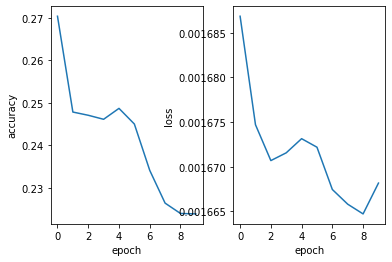

Data(x=[352, 13], edge_index=[2, 351], edge_attr=[351, 2], y=[1])


NameError: name 'to_networkx' is not defined

In [32]:
run_id = 1
os.makedirs(f'/home/sneha/airway_exploration/run_{run_id}/')
verbose= True
device = set_device_and_seed()
print("Device", device)

batch_size = 128
num_epochs = 2000
count_epochs = 0
test_every = 10


class_prop = my_data_train.class_proportions
class_weight_tensor = torch.tensor([1/class_prop[0], 1.5*1/class_prop[1]], dtype=float) # massivelyupweight loss on minority class x3
mag = class_weight_tensor.sum()
class_weight_tensor = class_weight_tensor/mag
print(class_weight_tensor)
train_loader = DataLoader(my_data_train, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)



model = GAT(agg='none',dropout=0.2, hidden_dim1=64, hidden_dim2=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
model.train()

train_accuracy = []
train_loss = []
while count_epochs <= (num_epochs-test_every):
    print(f"Training epochs: {count_epochs} to {count_epochs+test_every} ")
    plotting_dict_train = train_model(model, optimizer ,train_loader, device,num_epochs=test_every, count_epochs=count_epochs, verbose=verbose, class_weight =class_weight_tensor)
    count_epochs += test_every
    train_accuracy.extend(plotting_dict_train['accuracy'])
    train_loss.extend(plotting_dict_train['loss'])
    
    print("Visualise training progress")
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='train_accuracy')
    ax2.plot(np.arange(0,len(train_loss)), train_loss, label='train_loss')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('loss')
    plt.savefig(f'/home/sneha/airway_exploration/run_{run_id}/training_epoch_{count_epochs}')
    plt.show()
    
    if model.agg == 'none':
#         vis_ids are one anomalous and one normal all in train data not test
        for i in range(0,2):
            id_test = binary_label_df_train.iloc[np.argmax((binary_label_df_train.binaryLL_1==i))].idno
            index_test = [index for index, (idno, relabel) in train_loader.dataset.node_map.items() if idno==id_test][0]
            _vis_graph_example(train_loader,model, index_test, pilot_df_w_labels, visualise_g = False, save_path = f'/home/sneha/airway_exploration/run_{run_id}/training_vis_epoch_{count_epochs}_{i}')

In [ ]:
i, data = next(enumerate(train_loader))
from torch_geometric.utils import to_networkx, from_networkx
# label_maps = 
# label_maps


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



def train_one_epoch(epoch, model, train_loader, optimizer, device, weighted_loss=True):
    class_proportions = train_loader.dataset.class_proportions
    print("Class proportions", class_proportions)
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    model.train()
    model.to(device)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        # pred = model(batch.x.float(), 
        #                         batch.edge_attr.float(),
        #                         batch.edge_index, 
        #                         batch.batch) 
        pred = torch.sigmoid(model(batch.x, batch.edge_index, batch.batch))
        # Calculating the loss and gradients
        if weighted_loss:
            weights = batch.y.float().detach().clone()
            counts = weights.unique(return_counts=True)
            for idx in range(len(counts[0])):
                idx = int(idx)
                target = int(counts[0][idx].item())
                class_weight = 1 / class_proportions[target]
                # go through the classes in the batch
                # for values in the target tensor which have class 0/1,
                # replace with inverse proportion for that class
                weights[weights == counts[0][idx]] = class_weight
        else:
            weights = None
        loss =  F.binary_cross_entropy(pred.squeeze(), batch.y.float(), weight=weights)
        loss.requires_grad = True
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        # counting batches
        step += 1
    # loss average per epoch
    return running_loss/step

device = set_device_and_seed(GPU=False, seed=0)
plotting_dict_train = {}
plotting_dict_train['loss'] = []
plot_every = 100
num_epochs = 100
for i in range(num_epochs):
    loss = train_one_epoch(i, model, train_loader, optimizer, device, weighted_loss=True)
    plotting_dict_train['loss'].append(loss)
    print('Epoch: {}, Loss: {:.2f}'.format(i, loss))
    if i % plot_every == 0:
        plt.figure()
        plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])
        plt.show()
        

In [ ]:
plt.figure()
plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])